In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from pandas_profiling import ProfileReport

In [2]:
data = pd.read_parquet("data/safety-SanFrancisco.parquet")
display(data.head())
data.info()

,requestId,dataType,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source,extendedProperties
0,1,Safety,911_Fire,2018-10-02 11:54:01,Potentially Life-Threatening,Medical Incident,None,ELM ST/FRANKLIN ST,37.781286,-122.422187,None,
1,2,Safety,311_All,2018-07-08 15:00:27,Street and Sidewalk Cleaning,Bulky Items,Closed,"1536 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",37.791887,-122.418188,Mobile/Open311,
2,3,Safety,311_All,2016-06-28 13:12:28,General Request - COUNTY CLERK,customer_callback,Closed,Not associated with a specific address,0.000000,0.000000,Phone,
3,7,Safety,311_All,2017-03-03 09:34:49,Temporary Sign Request,Temporary Sign Request for Other_Event_Type,Closed,"2190 NORTH POINT ST, SAN FRANCISCO, CA, 94123",37.802853,-122.443245,Phone,
4,10,Safety,911_Fire,2016-10-25 18:33:20,Potentially Life-Threatening,Medical Incident,None,200 Block of DALEWOOD WAY,37.737953,-122.456498,None,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3958889 entries, 0 to 3958888
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   requestId           int64  
 1   dataType            object 
 2   dataSubtype         object 
 3   dateTime            object 
 4   category            object 
 5   subcategory         object 
 6   status              object 
 7   address             object 
 8   latitude            float64
 9   longitude           float64
 10  source              object 
 11  extendedProperties  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 362.4+ MB


### Data Prepping/Cleaning

In [3]:
# convert date column to correct type
data['dateTime'] = pd.to_datetime(data['dateTime'])

# convert empty strings to None type
data = data.replace('', np.nan, regex=True)

display(data.isna().sum())

# drop extendedProperties since all values are null
data.drop("extendedProperties", axis=1, inplace=True)

# drop duplicate rows
data.drop_duplicates(inplace=True, ignore_index=True)

# drop rows where lat and long are zero, but capture new data in a seperate dataframe
safety_data = data.query("latitude != 0 and longitude != 0")
safety_data.head()

requestId                   0
dataType                    0
dataSubtype                 0
dateTime                    0
category                 4933
subcategory                 0
status                1405089
address                     3
latitude                    0
longitude                   0
source                1405089
extendedProperties    3958889
dtype: int64

,requestId,dataType,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source
0,1,Safety,911_Fire,2018-10-02 11:54:01,Potentially Life-Threatening,Medical Incident,None,ELM ST/FRANKLIN ST,37.781286,-122.422187,None
1,2,Safety,311_All,2018-07-08 15:00:27,Street and Sidewalk Cleaning,Bulky Items,Closed,"1536 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",37.791887,-122.418188,Mobile/Open311
3,7,Safety,311_All,2017-03-03 09:34:49,Temporary Sign Request,Temporary Sign Request for Other_Event_Type,Closed,"2190 NORTH POINT ST, SAN FRANCISCO, CA, 94123",37.802853,-122.443245,Phone
4,10,Safety,911_Fire,2016-10-25 18:33:20,Potentially Life-Threatening,Medical Incident,None,200 Block of DALEWOOD WAY,37.737953,-122.456498,None
5,12,Safety,311_All,2020-04-10 12:45:00,Street and Sidewalk Cleaning,Medical Waste,Closed,"4 TURK ST, SAN FRANCISCO, CA, 94102",37.783520,-122.409487,Web


In [15]:
# curious about the types of emergency calls
safety_data['dataSubtype'].value_counts()

311_All     2444201
911_Fire    1405088
Name: dataSubtype, dtype: int64

### Looking at most frequent categories

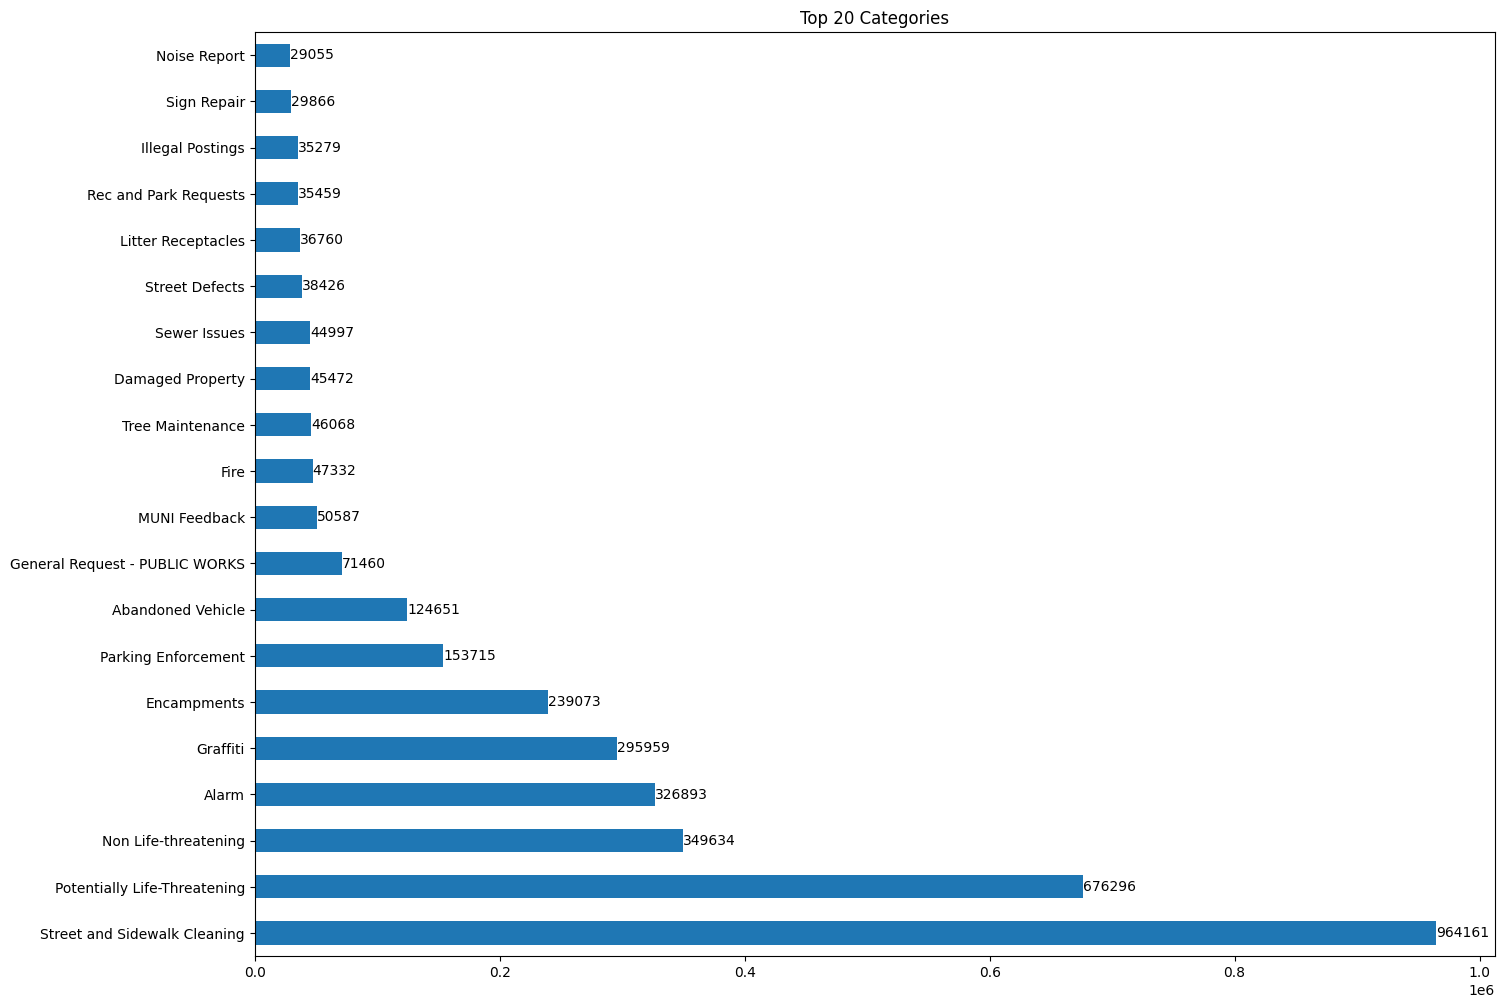

In [4]:
import matplotlib.pyplot as plt

categories = safety_data['category'].value_counts()[:20]
categories.name = 'count'
ax = categories.plot(kind="barh", figsize=(16,12), title="Top 20 Categories")
ax.bar_label(ax.containers[0])
plt.show()

In [5]:
percentages = (safety_data['category'].value_counts(normalize=True) * 100)[:20]
percentages.name = 'percentage'
table = pd.concat([categories,percentages],axis=1)
table

,count,percentage
Street and Sidewalk Cleaning,964161,25.079909
Potentially Life-Threatening,676296,17.591919
Non Life-threatening,349634,9.094735
Alarm,326893,8.503193
Graffiti,295959,7.698533
Encampments,239073,6.218805
Parking Enforcement,153715,3.998459
Abandoned Vehicle,124651,3.242442
General Request - PUBLIC WORKS,71460,1.858829
MUNI Feedback,50587,1.315877


Street and Sidewalk Cleaning represents a quarter of the categories. 
I'll look at the top 10 subcategories that are within Street and Sidewalk Cleaning

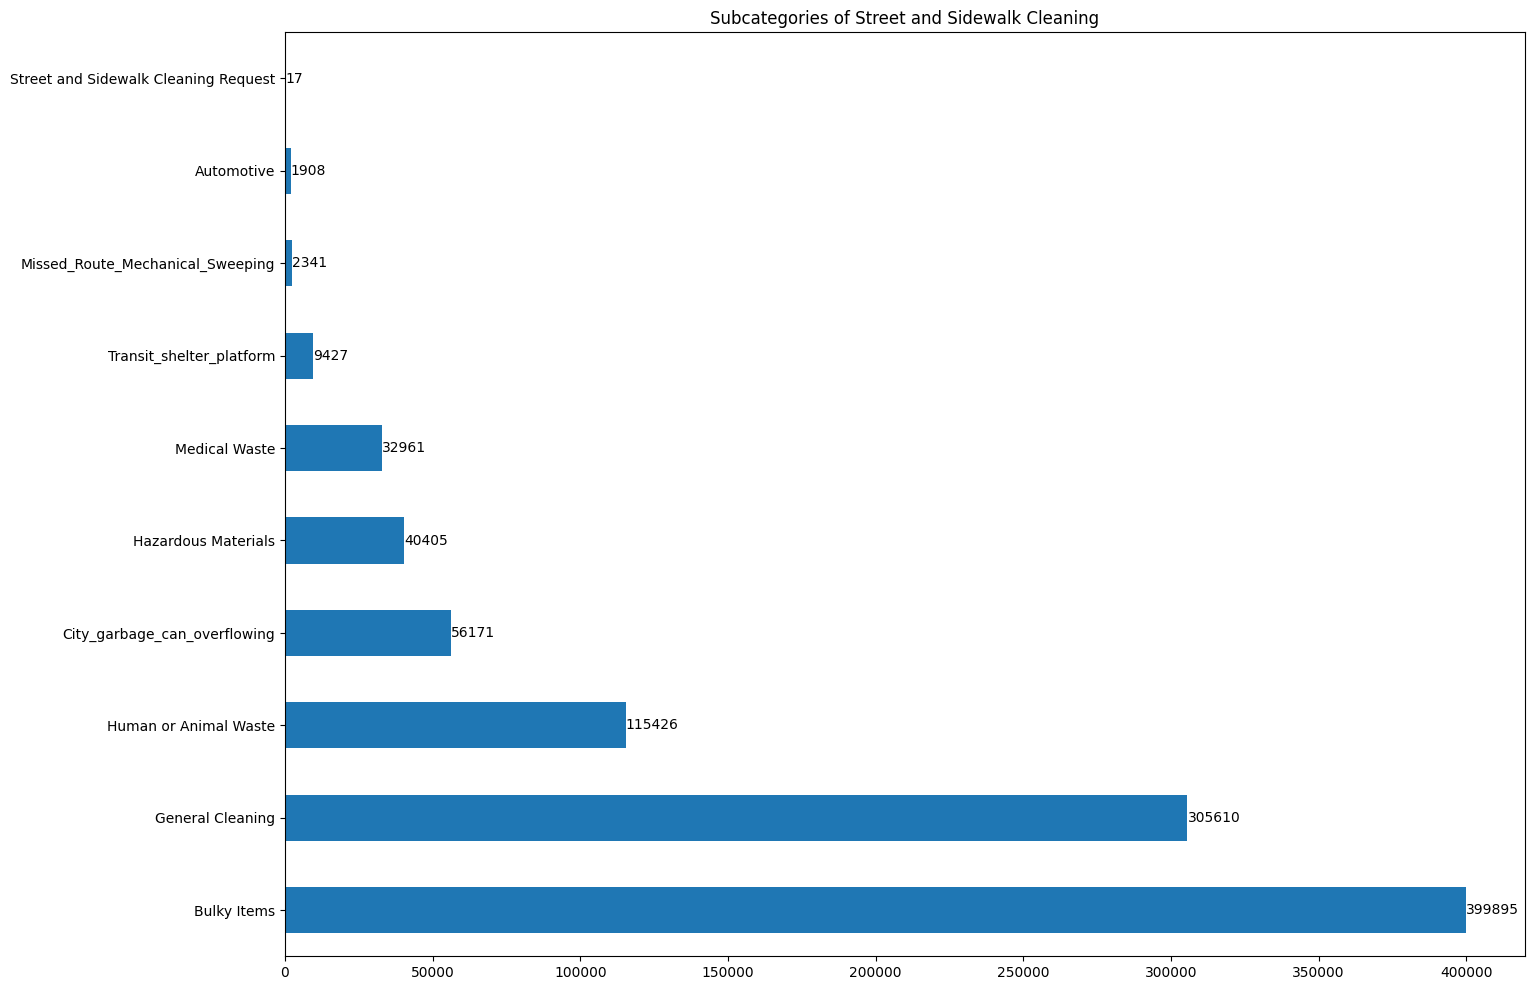

In [6]:
street_sidewalk_subcats = safety_data[safety_data['category'] == "Street and Sidewalk Cleaning"]['subcategory'].value_counts()[:10]
street_sidewalk_subcats.name = 'street_sidewalk_subcats'
ax = street_sidewalk_subcats.plot(kind="barh", figsize=(16,12), title="Subcategories of Street and Sidewalk Cleaning")
ax.bar_label(ax.containers[0])
plt.show()

I'll also look at the subcategories within Potentially Life-Threatening, Non Life-threatening, and Alarm 

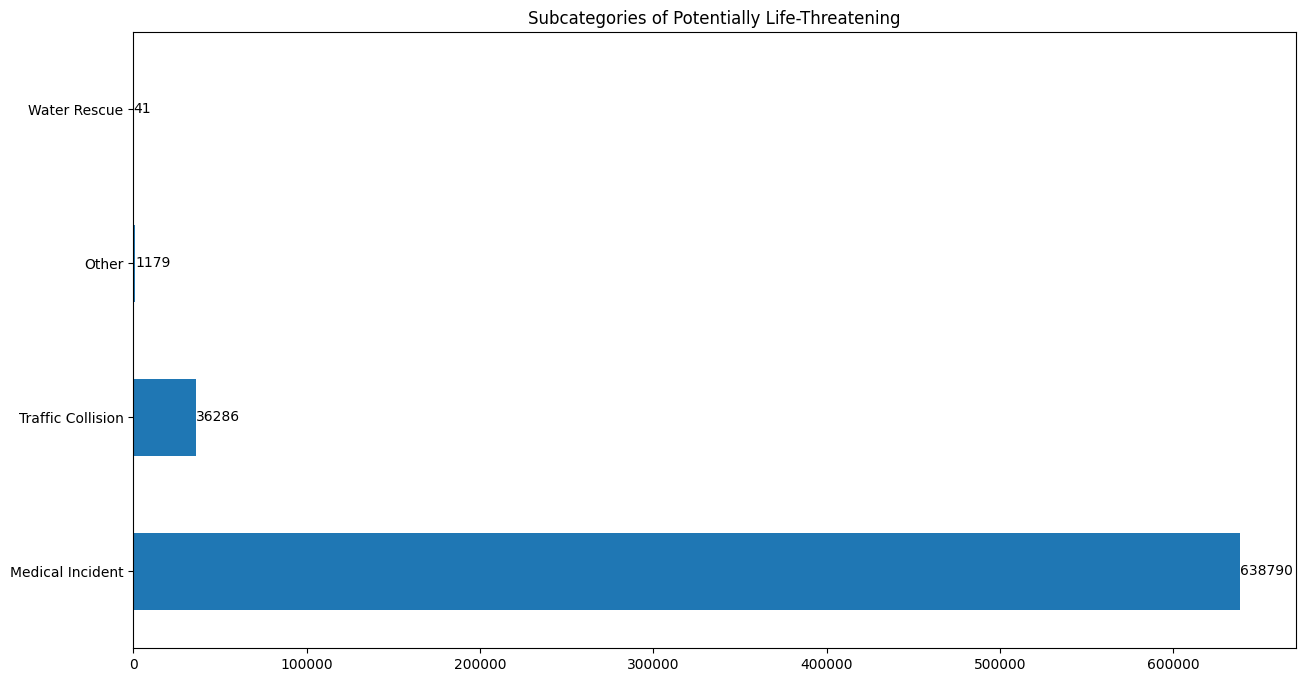

In [7]:
street_sidewalk_subcats = safety_data[safety_data['category'] == "Potentially Life-Threatening"]['subcategory'].value_counts()[:10]
street_sidewalk_subcats.name = 'street_sidewalk_subcats'
ax = street_sidewalk_subcats.plot(kind="barh", figsize=(15,8), title="Subcategories of Potentially Life-Threatening")
ax.bar_label(ax.containers[0])
plt.show()

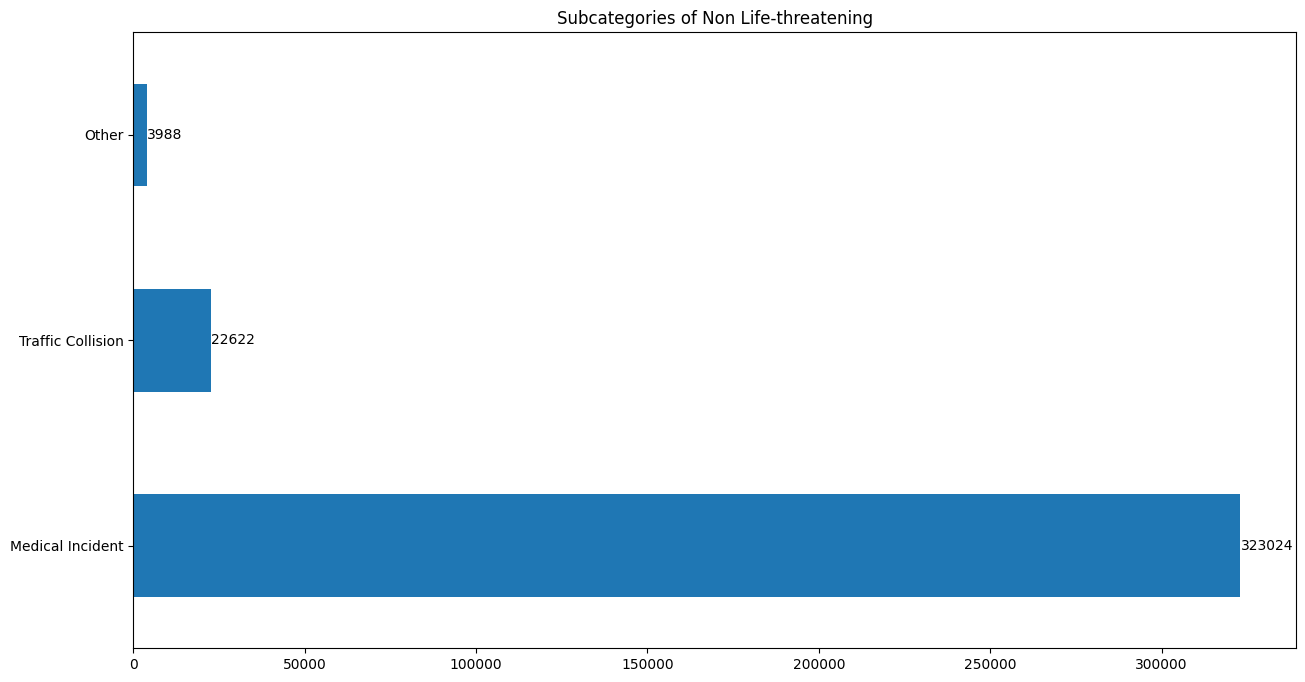

In [8]:
street_sidewalk_subcats = safety_data[safety_data['category'] == "Non Life-threatening"]['subcategory'].value_counts()[:10]
street_sidewalk_subcats.name = 'street_sidewalk_subcats'
ax = street_sidewalk_subcats.plot(kind="barh", figsize=(15,8), title="Subcategories of Non Life-threatening")
ax.bar_label(ax.containers[0])
plt.show()

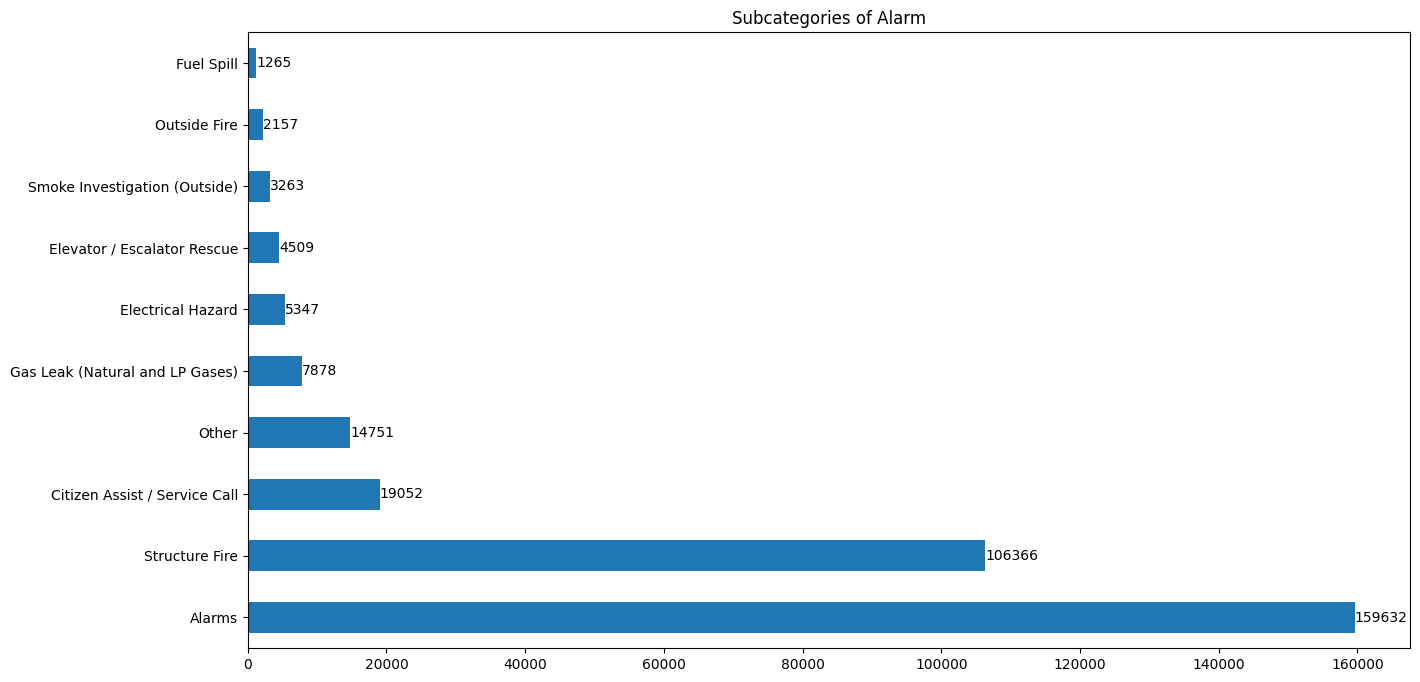

In [9]:
street_sidewalk_subcats = safety_data[safety_data['category'] == "Alarm"]['subcategory'].value_counts()[:10]
street_sidewalk_subcats.name = 'street_sidewalk_subcats'
ax = street_sidewalk_subcats.plot(kind="barh", figsize=(15,8), title="Subcategories of Alarm")
ax.bar_label(ax.containers[0])
plt.show()

### Look at most frequent address

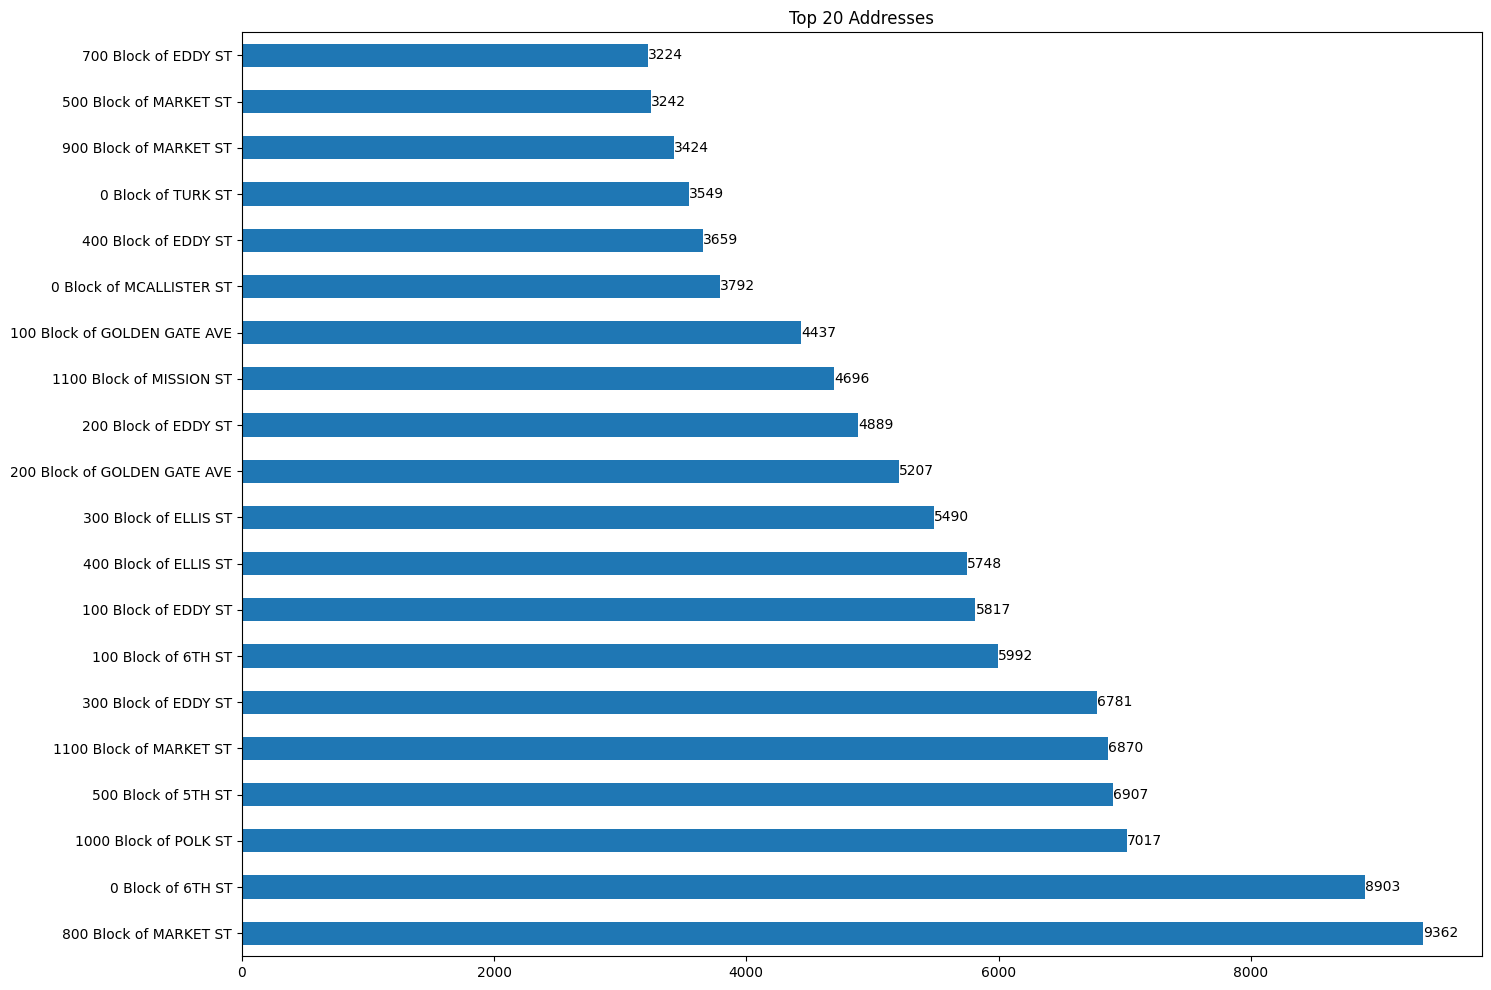

In [10]:
addresses = safety_data['address'].value_counts()[:20]
addresses.name = 'count'
ax = addresses.plot(kind="barh", figsize=(16,12), title="Top 20 Addresses")
ax.bar_label(ax.containers[0])
plt.show()

I'll plot these addresses using geopandas

In [11]:
mask = safety_data["address"].isin(addresses.index)
notorious_addresses = safety_data[mask]
notorious_addresses.reset_index(inplace=True, drop=True)
notorious_addresses

,requestId,dataType,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source
0,164,Safety,911_Fire,2018-06-04 11:28:39,Potentially Life-Threatening,Medical Incident,None,400 Block of ELLIS ST,37.784699,-122.413594,None
1,228,Safety,911_Fire,2018-01-09 19:10:10,Potentially Life-Threatening,Medical Incident,None,1100 Block of MISSION ST,37.777712,-122.412737,None
2,261,Safety,911_Fire,2017-05-13 18:20:58,Alarm,Other,None,0 Block of TURK ST,37.783386,-122.409854,None
3,292,Safety,911_Fire,2017-08-23 16:55:17,Alarm,Alarms,None,300 Block of ELLIS ST,37.784916,-122.411950,None
4,451,Safety,911_Fire,2020-06-04 22:52:11,Alarm,Alarms,None,1100 Block of MARKET ST,37.779531,-122.413543,None
...,...,...,...,...,...,...,...,...,...,...,...
109001,1202595,Safety,911_Fire,2019-08-19 06:59:45,Alarm,Alarms,None,300 Block of ELLIS ST,37.785025,-122.411972,None
109002,1202667,Safety,911_Fire,2016-02-23 16:37:03,Potentially Life-Threatening,Medical Incident,None,500 Block of MARKET ST,37.790070,-122.400173,None
109003,1202718,Safety,911_Fire,2019-09-18 17:25:37,Alarm,Alarms,None,400 Block of ELLIS ST,37.784807,-122.413615,None
109004,1202890,Safety,911_Fire,2018-06-23 18:07:59,Potentially Life-Threatening,Medical Incident,None,300 Block of EDDY ST,37.783834,-122.412931,None


In [12]:
geopoints = notorious_addresses.groupby(['address', 'latitude', 'longitude']).size().sort_values(ascending=False).reset_index(name='Freq')[:20]
geopoints

,address,latitude,longitude,Freq
0,1000 Block of POLK ST,37.786117,-122.419854,5265
1,500 Block of 5TH ST,37.777624,-122.399981,5120
2,1100 Block of MARKET ST,37.779531,-122.413543,3213
3,0 Block of 6TH ST,37.781146,-122.409026,3206
4,200 Block of GOLDEN GATE AVE,37.781865,-122.414285,2958
5,400 Block of ELLIS ST,37.784807,-122.413615,2887
6,800 Block of MARKET ST,37.784346,-122.407785,2760
7,100 Block of EDDY ST,37.784299,-122.410141,2755
8,300 Block of ELLIS ST,37.785025,-122.411972,2621
9,0 Block of TURK ST,37.783386,-122.409854,2541


There is a discrepency between the most frequent addresses in the above table vs the graph. I think it has something to do with how latitude/longitudes can vary slightly but still reference the same address.